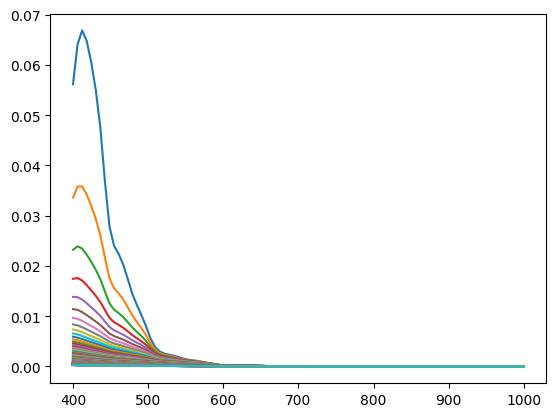

In [2]:
#!/usr/bin/env python
# coding=utf-8

# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

from scipy.interpolate import InterpolatedUnivariateSpline, Akima1DInterpolator
# ------------------------------------------------------------------------------


# ##############################################################################
class Hyperspectral(object):
    """docstring for Hyperspectral"""
# ------------------------------------------------------------------------------
    def __init__(self, wvl):
        super(Hyperspectral, self).__init__()
        self.wvl = wvl
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def _read_model_data(self, datafile):

        data = np.genfromtxt(datafile)
        return data[:, 0], data[:, 1]
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def _interp_data(self, wvl, data, extra_flag=True):
        """
        extra_flag is used to allow extrapolation with spline.
        """
        interpolator = Akima1DInterpolator(wvl, data)
        data_new = interpolator(self.wvl)
        if np.any(np.isnan(data_new)) and extra_flag:

            try:
                # Try to extrapolate just in using intial data
                extrapolator = InterpolatedUnivariateSpline(wvl, data)
            except:
                # if it's failed, the extrapolation is performed in using
                # interpolated data
                ind_not_nan = np.where(np.isnan(data_new)==False)
                extrapolator = InterpolatedUnivariateSpline(
                    self.wvl[ind_not_nan], data_new[ind_not_nan])

            ind_nan = np.where(np.isnan(data_new))
            data_new[ind_nan] = extrapolator(self.wvl[ind_nan])

        return data_new
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def resample(self, init_sp, wvl, fwhm):
        resamp_data = np.zeros(wvl.shape)
        dwvl = self.wvl[1] - self.wvl[0]
        for i_wvl in range(wvl.shape[0]):
            sigma = fwhm[i_wvl]/(2.*np.sqrt(2*np.log(2)))
            filter_coeff = 1./(sigma*np.sqrt(2*np.pi)) * \
                np.exp(-0.5*((self.wvl-wvl[i_wvl])**2)/(sigma**2))
            filter_coeff = filter_coeff*dwvl
            resamp_data[i_wvl] = np.inner(filter_coeff, init_sp)
        return resamp_data
# ------------------------------------------------------------------------------
# ##############################################################################


# ##############################################################################
class Water(Hyperspectral):
    """docstring for Water"""
# ------------------------------------------------------------------------------
    def __init__(self, wvl,
                 awater_file,
                 abwater, ebwater,
                 aphy_file, ephy_file,
                 anap, snap,
                 scdom,
                 abp, ebp, bfp):
        super(Water, self).__init__(wvl)
        # For water absorption
        wvl_awater, awater = self._read_model_data(awater_file)
        self.awater = self._interp_data(wvl_awater, awater)
        # For chlorophyl absorption
        wvl_aphy, aphy = self._read_model_data(aphy_file)
        wvl_ephy, ephy = self._read_model_data(ephy_file)
        self.aphy = self._interp_data(wvl_aphy, aphy)
        self.ephy = self._interp_data(wvl_ephy, ephy)
        self.aphy = np.maximum(self.aphy, 0.)
        self.ephy = np.maximum(self.ephy, 0.)
        # For non algal absorption
        self.anap = anap
        self.snap = snap
        # For cdom absorption
        self.scdom = scdom
        # For water scatterring
        self.bwater = self.get_bwater(abwater, ebwater)
        # For particles scattering
        self.bfp = bfp
        self.abp = abp
        self.ebp = ebp
# ------------------------------------------------------------------------------


# ------------------------------------------------------------------------------
    def get_aphy(self, chloro_conc):
        # concentation in mg/m3
        return self.aphy * (chloro_conc)**(self.ephy)
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def get_anap(self, tsm):
        # total suspended matter in g/m3
        return tsm * self.anap * np.exp(-self.snap * (self.wvl - 443.))
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def get_acdom(self, cdom_abs):
        # absorption in  m-1
        return cdom_abs * np.exp(-self.scdom * (self.wvl - 443.))
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def get_bwater(self, abwater, ebwater):
        return abwater * (self.wvl/500.)**(ebwater)
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def get_bp(self, tsm):
        # total suspended matter in g/m3
        return tsm * self.abp * (self.wvl/555.)**(self.ebp)
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def get_absorption(self, chloro_conc, cdom, tsm):
        return self.awater + self.get_aphy(chloro_conc) + \
            self.get_acdom(cdom) + self.get_anap(tsm)
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def get_total_scat(self, tsm):
        return self.bwater + self.get_bp(tsm)
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def get_back_scat(self, tsm):
        return 0.5*self.bwater + self.bfp * self.get_bp(tsm)
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
    def rrsm_inf(self, chl, cdom, tsm, thetaw, theta):
        # From Albert Mobley 2003
        # thetaw : subsurface solar zenith angle in radian
        # theta : subsurface viewing angle in radian

        p1, p2, p3, p4, p5, p6, p7 = \
            0.0512, 4.6659, -7.8387, 5.4571, 0.1098, -0.0044, 0.4021

        a = self.get_absorption(chl, cdom, tsm)
        bb = self.get_back_scat(tsm)

        u = bb/(a+bb)

        # Albert Mobley 2003[Eq. 9]
        return p1*(1+p2*u+p3*u**2+p4*u**3) * \
            (1+p5/np.cos(thetaw)) * (1+p6*u) * \
            (1+p7/np.cos(theta))*u
# ------------------------------------------------------------------------------
# ##############################################################################


if __name__ == '__main__':
    # For test
    import matplotlib.pyplot as plt

    r_inf_data = []


    wvl = np.linspace(400, 1000, 100)
    awater_file = "awater.txt"
    abwater = 0.00288 # can be fixed
    ebwater = -4.32 # can be fixed
    aphy_file = "aphys.txt"
    ephy_file = "ephys.txt"
    anap = 0.036
    snap = 0.0123
    scdom = 0.017 # change this variable and fix all other for now
    abp = 0.42
    ebp = -0.2
    bfp = 0.0183

    water_param = Water(wvl,
                        awater_file,
                        abwater, ebwater,
                        aphy_file, ephy_file,
                        anap, snap,
                        scdom,
                        abp, ebp, bfp)

    theta_v, theta_s = np.radians(0), np.radians(30)

    df = pd.DataFrame()  # Create an empty DataFrame

    for cdom_values in np.arange(0, 1, 0.005):
        r_inf_test = water_param.rrsm_inf(0, cdom_values, 0.0005, theta_s, theta_v)

    # Create a new DataFrame for each iteration
        iteration_df = pd.DataFrame({
        f'cdom_{cdom_values}': cdom_values,
        f'wvl_{cdom_values}': wvl,
        f'r_inf_test_{cdom_values}': r_inf_test
    })

        # Append the iteration DataFrame to the main DataFrame
        df = pd.concat([df, iteration_df], axis=1)

        # Plot the data for the current iteration
        plt.plot(wvl, r_inf_test, label='Line '+str(cdom_values))

# Save the main DataFrame to CSV
df.to_csv('graph_data_cdom.csv', index=False)